Settings: Signal To Noise Limit
===============================

This example demonstrates how to use a signal-to-noise limits in the phase settings, which fits data where the
noise-map is increased to cap the highest signal-to-noise value.

The benefits of this are:

 - Model fitting may be subject to over-fitting the highest signal-to-noise regions of the image instead of
      providing a global fit to the entire image. For example, if a lensed source has 4 really bright, compact, high
      S/N images which are not fitted perfectly by the model, their high chi-squared contribution will drive the model
      fit to place more light in those regions, ignoring the lensed source's lower S/N more extended arcs. Limiting the
      S/N of these high S/N regions will reduce over-fitting. The same logic applies for foreground lens light
      subtractions which are not perfect andn leave large chi-squared residuals.

      To learn more about this over-fitting problem, checkout chapter 5 of the `HowToLens` lecture series.

 - If the model-fit has extremely large chi-squared values due to the high S/N of the dataset. The non-linear
      search will take a long time exploring this `extreme` parameter space. In the early phases of a pipeline this
      often isn't necessary, therefore a signal-to-noise limit can reduce the time an analysis takes to converge.

The downsides of this are:

 - Reducing the S/N of you data may significantly increase the errors of the lens model that you infer.

 - The noise-map of your data will no longer reflect the true noisy properties of the data, which could bias the
      lens model inferred.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


I`ll assume that you are familiar with the beginner example scripts work, so if any code doesn`t make sense familiarize
yourself with those first!

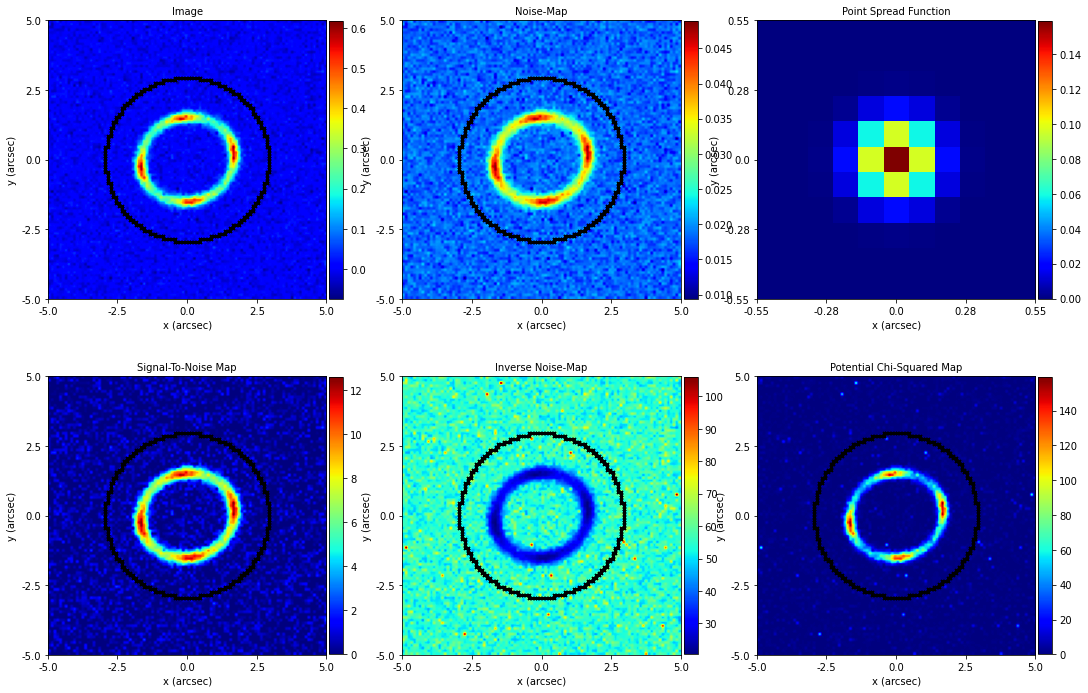

In [2]:
dataset_name = "mass_sie__source_sersic"
pixel_scales = 0.1

dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=pixel_scales,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

we'll fit a `EllipticalIsothermal` + `EllipticalSersic` model which we often fitted in the beginner example scripts.

In [3]:
lens = al.GalaxyModel(redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = al.GalaxyModel(redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

Next, we specify the `SettingsPhaseImaging`, which describe how the model is fitted to the data in the log likelihood
function. In this example, we specify:

 - A signal_to_noise_limit of 10.0, which increases the noise values in the noise-map such that no pixel has a S/N
above 10.0.

In [4]:
settings_masked_imaging = al.SettingsMaskedImaging(signal_to_noise_limit=0.1)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Search__

we'll use the default `DynestyStatic` sampler we used in the beginner examples.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/settings/mass_sie__source_sersic/phase_signal_to_noise_limit`.

However, because the `SettingsPhase` include a signal_to_noise_limit, the output path is tagged to reflelct this, 
meaning the full output path is:

 `/autolens_workspace/output/examples/settings/mass_sie__source_sersic/phase_signal_to_noise_limit/settings__snr_10`.

In [5]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "settings"),
    name="phase_signal_to_noise_limit",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

In [6]:
phase = al.PhaseImaging(
    search=search,
    galaxies=af.CollectionPriorModel(lens=lens, source=source),
    settings=settings,
)

phase.run(dataset=imaging, mask=mask)

INFO:root:phase_signal_to_noise_limit already completed, skipping non-linear search.


Finish.